In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy.io as sio
from fundamental_matrix_estimation import *

In [2]:
im_set='../data/set1'
# Lire les données
im1 = cv2.imread(im_set+'/image1.jpg')
im2 = cv2.imread(im_set+'/image2.jpg')
points1 = get_data_from_txt_file(im_set+'/pt_2D_1.txt')
points2 = get_data_from_txt_file(im_set+'/pt_2D_2.txt')

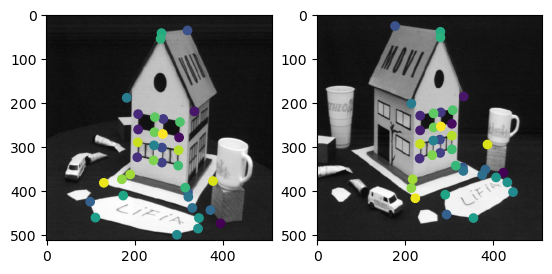

In [3]:
plt.subplot(121)
plt.imshow(im1)
plt.scatter(points1[:,0],points1[:,1],c=np.arange(len(points1)))
plt.subplot(122)
plt.imshow(im2)
plt.scatter(points2[:,0],points2[:,1],c=np.arange(len(points1)))

In [4]:
F = normalized_eight_point_alg(points1, points2)

* Après avoir obtenu la matrice fondamentale, nous pouvons calculer les lignes épipolaires $\ell_i$ et $\ell_i'$ pour chaque correspondance $p_i$ et $p_i'$ .

* Nous pouvons calculer les lignes épipolaires $\ell'=F^Tp$ et $\ell=Fp'$ à partir de la matrice fondamentale et des points correspondants.

* Rappelons que chaque ligne épipolaire peut être représentée par un vecteur $\ell$ tel que tous les points de la ligne sont dans l'ensemble ${x|\ell^T x = 0}$.

* Si nous définissons chaque ligne épipolaire comme $\ell_i=[\ell_{i,1},\ell_{i,2},\ell_{i,3}]^T$ , alors nous pouvons formuler un système linéaire d'équations et le résoudre en utilisant la SVD pour trouver l'épipole e :

$$\begin{bmatrix}
\ell^T_1\\
\vdots\\
\ell^T_n
\end{bmatrix}e=0$$

In [5]:
def compute_epipole(points1, points2, F):
    l = F.T.dot(points2.T).T
    U, s, VT = np.linalg.svd(l)
    e = VT[-1, :]
    # normaliser
    e /= e[2]
    return e

In [6]:
e1 = compute_epipole(points1, points2, F)
e2 = compute_epipole(points2, points1, F.transpose())
print("epipole de limage de gauche", e1)
print("epipole de limage de droite", e2)

epipole de limage de gauche [-1.30017381e+03 -1.42178443e+02  1.00000000e+00]
epipole de limage de droite [1.65402039e+03 4.53130376e+01 1.00000000e+00]


* Après avoir trouvé les épipole, nous remarquerons probablement qu'ils ne sont pas des points à l'infini le long de l'axe horizontal.

* Nous voulons trouver une paire d'homographies H1, H2 que nous pouvons appliquer aux images pour cartographier les épipoles à l'infini.

* Commençons par trouver une homographie $H_2$


* La première étape de cette transformation consiste à traduire la deuxième image de telle sorte que le centre soit situé à (0, 0, 1) en coordonnées homogènes. Pour ce faire, nous appliquons la matrice de translation

$$T=\begin{bmatrix}
1 & 0 & \frac{-W}{2}\\
 0& 1 & \frac{-H}{2}\\
 0&0  & 1
\end{bmatrix}, $$

In [7]:
# calculer H2
width = im2.shape[1]
height = im2.shape[0]

T = np.identity(3)
T[0][2] = -1.0 * width / 2
T[1][2] = -1.0 * height / 2

* Après avoir appliqué la translation, nous appliquons une rotation pour placer l'épipole sur l'axe horizontal en un point (f, 0, 1).

In [8]:

e = T.dot(e2)
e1_prime = e[0]
e2_prime = e[1]
if e1_prime >= 0:
        alpha = 1.0
else:
        alpha = -1.0


* Si l'épipôle translaté $Te'$ est situé aux coordonnées homogènes $(e_1' , e_2' , 1)$, la rotation appliquée est la suivante
$$R=\begin{bmatrix}
\alpha \frac{e_1'}{\sqrt{e^{2'}_1+e^{2'}_2}} & \alpha \frac{e_2'}{\sqrt{e^{2'}_1+e^{2'}_2}} & 0\\
-\alpha \frac{e_2'}{\sqrt{e^{2'}_1+e^{2'}_2}}  & \alpha \frac{e_1'}{\sqrt{e^{2'}_1+e^{2'}_2}} &0 \\
0 & 0 & 1
\end{bmatrix}$$
* où $\alpha = 1$ si $e_1'  ≥ 0$ et $\alpha = -1$ sinon

In [9]:


R = np.identity(3)
R[0][0] = alpha * e1_prime / np.sqrt(e1_prime**2 + e2_prime**2)
R[0][1] = alpha * e2_prime / np.sqrt(e1_prime**2 + e2_prime**2)
R[1][0] = - alpha * e2_prime / np.sqrt(e1_prime**2 + e2_prime**2)
R[1][1] = alpha * e1_prime / np.sqrt(e1_prime**2 + e2_prime**2)



* Après avoir appliqué cette rotation, on remarque qu'étant donné un point quelconque à (f, 0, 1), le ramener à un point à l'infini sur l'axe horizontal (f, 0, 0) ne nécessite que l'application d'une transformation

$$G=\begin{bmatrix}
1 &  0& 0\\
0 &  1& 0\\
\frac{-1}{f} & 0 &1
\end{bmatrix},$$

In [10]:
f = R.dot(e)[0]
G = np.identity(3)
G[2][0] = - 1.0 / f

Ainsi, l'homographie H2 que nous appliquons sur la seconde image pour la rectifier est

$$H_2=T^{-1}GRT$$

In [11]:


H2 = np.linalg.inv(T).dot(G.dot(R.dot(T)))

* Maintenant qu'une $H_2$ valide a été trouvée, nous devons trouver une homographie correspondante H1 pour la première image.

* Pour ce faire, nous trouvons une transformation $H_1$ qui minimise la somme des carrés des distances entre les points correspondants des images
$$argmin_{H_1}\sum_i \left \| H_1p_i-H_2p_i' \right \|^2$$

* Bien que la dérivation2 sorte du cadre de ce cours, nous pouvons prouver que l'appariement $H_1$ est de la forme :
$$H_1=H_AH_2M$$

où  
$$M=[e]_xF+ev^T \quad v=\begin{bmatrix}
1\\
1\\
1
\end{bmatrix}$$



* Pour rappel
$$[e]_x=\begin{bmatrix}
0 & -e_z & e_y\\
e_z &0  &-e_x \\
 -e_y&e_x  & 0
\end{bmatrix}$$

In [12]:
# calculer H1
e_prime = np.zeros((3, 3))
e_prime[0][1] = -e2[2]
e_prime[0][2] = e2[1]
e_prime[1][0] = e2[2]
e_prime[1][2] = -e2[0]
e_prime[2][0] = -e2[1]
e_prime[2][1] = e2[0]

v = np.array([1, 1, 1])
M = e_prime.dot(F) + np.outer(e2, v)



et $H_A$ est de la form
$$H_A=\begin{bmatrix}
a_1 &  a_2& a_3\\
0 &0  & 0\\
0 &0  & 0
\end{bmatrix}$$
et minimise
$$argmin_{H_A} \sum_i \left \| H_A \hat{p}_i-\hat{p}_i' \right \|, \quad \hat{p}_i=H_2 Mp,\hat{p}_i'=H_2 p_i'$$



* En particulier, si nous laissons $\hat{p}_i = (\hat{x}_i , \hat{y}_i , 1) $ et $\hat{p}'_i = (\hat{x}'_i , \hat{y}'_i , 1)$, alors le problème de minimisation peut être remplacé par :

$$argmin_{H_A}\sum_i(a_1\hat{x}_i+a_2\hat{y}_i+a_3+\hat{x}'_i)^2$$

* En fin de compte, cela revient à résoudre le problème des moindres carrés Wa = b pour a où

$$W=\begin{bmatrix}
\hat{x}_1 &\hat{y}_1  & 1\\
\vdots &  \vdots&1 \\
\hat{x}_n& \hat{x}_n & 1
\end{bmatrix},\quad b=\begin{bmatrix}
\hat{x}'_1\\
\vdots\\
\hat{x}'_n
\end{bmatrix}$$

In [13]:
points1_hat = H2.dot(M.dot(points1.T)).T
points2_hat = H2.dot(points2.T).T

W = points1_hat / points1_hat[:, 2].reshape(-1, 1)
b = (points2_hat / points2_hat[:, 2].reshape(-1, 1))[:, 0]

In [14]:


# problème des moindres carrés
a1, a2, a3 = np.linalg.lstsq(W, b)[0]
HA = np.identity(3)
HA[0] = np.array([a1, a2, a3])

H1 = HA.dot(H2).dot(M)

C:\Users\nmadali\AppData\Local\Temp\ipykernel_21304\4094314994.py:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  a1, a2, a3 = np.linalg.lstsq(W, b)[0]


In [15]:
# Transforming the images by the homographies
new_points1 = H1.dot(points1.T)
new_points2 = H2.dot(points2.T)
new_points1 /= new_points1[2,:]
new_points2 /= new_points2[2,:]
new_points1 = new_points1.T
new_points2 = new_points2.T



In [16]:
def compute_rectified_image(im, H):
    new_x = np.zeros(im.shape[:2])
    new_y = np.zeros(im.shape[:2])
    for y in range(im.shape[0]): # height
        for x in range(im.shape[1]): # width
            new_location = H.dot([x, y, 1])
            new_location /= new_location[2]
            new_x[y,x] = new_location[0]
            new_y[y,x] = new_location[1]
    offsets = (new_x.min(), new_y.min())
    new_x -= offsets[0]
    new_y -= offsets[1]
    new_dims = (int(np.ceil(new_y.max()))+1,int(np.ceil(new_x.max()))+1)

    H_inv = np.linalg.inv(H)
    new_image = np.zeros((new_dims[0],new_dims[1],3))

    for y in range(new_dims[0]):
        for x in range(new_dims[1]):
            old_location = H_inv.dot([x+offsets[0], y+offsets[1], 1])
            old_location /= old_location[2]
            old_x = int(old_location[0])
            old_y = int(old_location[1])
            if old_x >= 0 and old_x < im.shape[1] and old_y >= 0 and old_y < im.shape[0]:
                new_image[y,x] = im[old_y, old_x]

    return new_image.astype('uint8'), offsets


In [17]:
rectified_im1, offset1 = compute_rectified_image(im1, H1)
rectified_im2, offset2 = compute_rectified_image(im2, H2)
new_points1 -= offset1 + (0,)
new_points2 -= offset2 + (0,)

In [18]:
np.min(rectified_im1),np.max(rectified_im1)

(0, 255)

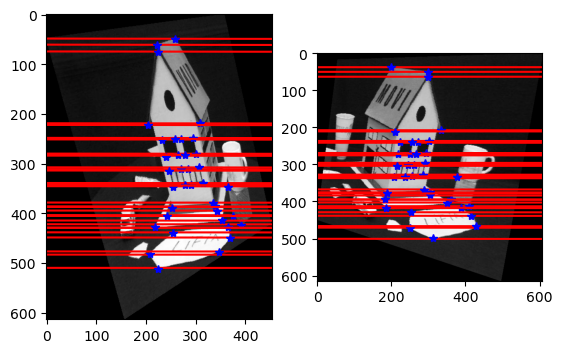

In [19]:
# Tracer l'image
F_new = normalized_eight_point_alg(new_points1, new_points2)
plot_epipolar_lines_on_images(new_points1, new_points2, rectified_im1, rectified_im2, F_new)
plt.show()
